In [77]:
# Notebook to get started on the evaluation

In [78]:
# Imports
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt

# Make sure you have pytorch installed
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

# Make sure you place L96_model in the same folder as the notebook! 
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

In [79]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [80]:
# Simple regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

# Simple Neural Network
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 1 inputs
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 1)  # 1 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class NonLocal_FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 64)  # 8 inputs
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 8) # 8 outputs
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x

# Add your own modified NN here and make sure you load the weights!!

In [81]:
linear_weights = torch.load("linear.pth")
local_FCNN_weights = torch.load("local_NN.pth")
nonlocal_FCNN_weights = torch.load("non_local_NN.pth")

# Initialize network instances and assign pre-trained weights.
linear_network = LinearRegression()
linear_network.load_state_dict(linear_weights)

local_fcnn_network = FCNN()
local_fcnn_network.load_state_dict(local_FCNN_weights)

nonlocal_fcnn_network = NonLocal_FCNN()
nonlocal_fcnn_network.load_state_dict(nonlocal_FCNN_weights)

<All keys matched successfully>

In [82]:
# L96 without Y
class GCM_without_parameterization:
    """GCM without parameterization

    Args:
        F: Forcing term
        time_stepping: Time stepping method
    """

    def __init__(self, F, time_stepping=RK4):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [83]:
# L96 with P_NN(X)
class GCM_network:
    """GCM with neural network parameterization

    Args:
        F: Forcing term
        network: Neural network
        time_stepping: Time stepping method
    """

    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X)
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0))

        # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy())

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [84]:
# Forecasting parameters
T_test = 10
forcing = 18
dt = 0.01

k = 8 # 8 default
j = 32 #32 default Changement de j pour condition initial ^

W = L96(k, j, F=forcing)

# Full L96 model (two time scale model)
X_full, _, _ = W.run(dt, T_test)
X_full = X_full.astype(np.float32)

init_conditions = X_full[0, :]

In [85]:
gcm_no_param = GCM_without_parameterization(forcing)
X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

In [86]:
# Evaluate with linear network
def init_model (T_test):
    gcm_linear_net = GCM_network(forcing, linear_network)
    Xnn_linear, t = gcm_linear_net(init_conditions, dt, int(T_test / dt), linear_network)
    
    # Evaluate with local FCNN
    gcm_local_net = GCM_network(forcing, local_fcnn_network)
    Xnn_local, t = gcm_local_net(init_conditions, dt, int(T_test / dt), local_fcnn_network)
    
    # Evaluate with nonlocal FCNN
    gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
    Xnn_nonlocal, t = gcm_nonlocal_net(init_conditions, dt, int(T_test / dt), nonlocal_fcnn_network)
    
    return Xnn_linear, Xnn_local, Xnn_nonlocal, t

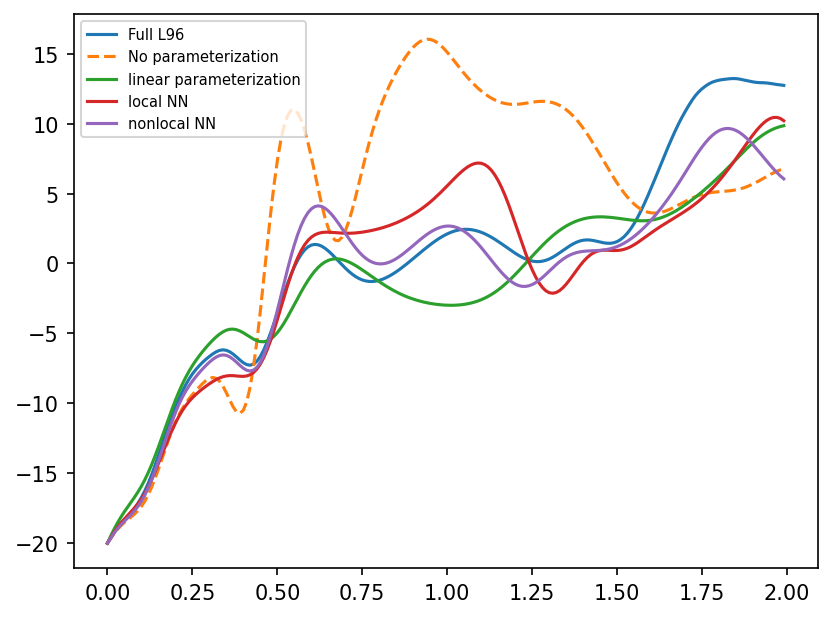

In [87]:
time_i = 200
Xnn_linear, Xnn_local, Xnn_nonlocal,t = init_model(T_test)
plt.figure(dpi=150)
plt.plot(t[:time_i], X_full[:time_i, 4], label="Full L96")
plt.plot(t[:time_i], X_no_param[:time_i, 4], "--", label="No parameterization")

plt.plot(t[:time_i], Xnn_linear[:time_i, 4], label="linear parameterization")

plt.plot(t[:time_i], Xnn_local[:time_i, 4], label="local NN")
plt.plot(t[:time_i], Xnn_nonlocal[:time_i, 4], label="nonlocal NN")
plt.legend(loc="upper left", fontsize=7);

In [88]:
err_linear, err_local, err_nonlocal = [], [], []
T_test = 1

for i in range(90):
    init_conditions_i = X_full[i * 10, :]

    Xnn_linear, Xnn_local, Xnn_nonlocal,t = init_model(T_test)

    # GCM parameterized by the global 3-layer network
    # gcm_net_3layers = GCM_network(forcing, nn_3l)
    # Xnn_3layer_i, t = gcm_net_3layers(init_conditions_i, dt, int(T_test / dt), nn_3l)

    # GCM parameterized by the linear network
    # gcm_net_1layers = GCM_network(forcing, linear_network)
    # Xnn_1layer_i, t = gcm_net_1layers(init_conditions_i, dt, int(T_test / dt), linear_network)

    err_linear.append(np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_linear)))

    err_local.append(np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_local)))

    err_nonlocal.append(np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal)))


print(f"Sum of errors for linear: {sum(err_linear):.2f}")
print(f"Sum of errors for local neural network: {sum(err_local):.2f}")
print(f"Sum of errors for non-local neural network: {sum(err_nonlocal):.2f}")

Sum of errors for linear: 444922.94
Sum of errors for local neural network: 452355.71
Sum of errors for non-local neural network: 457867.32


Shapes :
  Xnn_linear    : (101, 8)
  X_full_window : (101, 8)


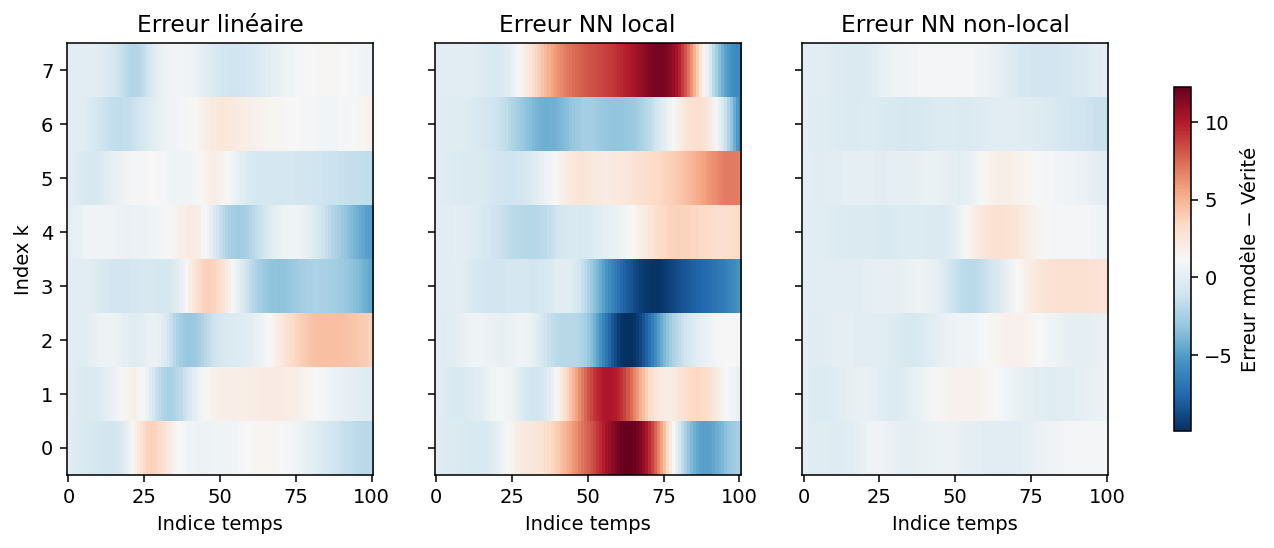

In [89]:
T_test = 1.0
n_steps = int(T_test / dt)
i0 = 0
init_conditions_i0 = X_full[i0 * 10, :]

#1 prevision par modèle
Xnn_linear, Xnn_local, Xnn_nonlocal,t = init_model(T_test)

#Vérité
i0=0
# Longueur réelle renvoyée par le GCM (souvent n_steps + 1)
n_steps_model, K = Xnn_linear.shape  # K = nombre de points de grille

# Fenêtre de vérité de même longueur que les prévisions
X_full_window = X_full[i0 * 10 : i0 * 10 + n_steps_model, :]

print("Shapes :")
print("  Xnn_linear    :", Xnn_linear.shape)
print("  X_full_window :", X_full_window.shape)

#erreurs
err_linear   = Xnn_linear   - X_full_window
err_local    = Xnn_local    - X_full_window
err_nonlocal = Xnn_nonlocal - X_full_window

#figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=140, sharey=True)

vmin = np.min([err_linear.min(), err_local.min(), err_nonlocal.min()])
vmax = np.max([err_linear.max(), err_local.max(), err_nonlocal.max()])

#Linéaire
im0 = ax[0].imshow(err_linear.T,aspect="auto",origin="lower",vmin=vmin, vmax=vmax,cmap="RdBu_r")
ax[0].set_title("Erreur linéaire")
ax[0].set_xlabel("Indice temps")
ax[0].set_ylabel("Index k")

#NN local
im1 = ax[1].imshow(err_local.T,aspect="auto",origin="lower",vmin=vmin, vmax=vmax,cmap="RdBu_r")
ax[1].set_title("Erreur NN local")
ax[1].set_xlabel("Indice temps")

#NN non-local
im2 = ax[2].imshow(err_nonlocal.T,aspect="auto",origin="lower",vmin=vmin, vmax=vmax,cmap="RdBu_r")
ax[2].set_title("Erreur NN non-local")
ax[2].set_xlabel("Indice temps")

# Barre de couleur
cbar = fig.colorbar(im2, ax=ax.ravel().tolist(), shrink=0.8)
cbar.set_label("Erreur modèle − Vérité")

plt.show()


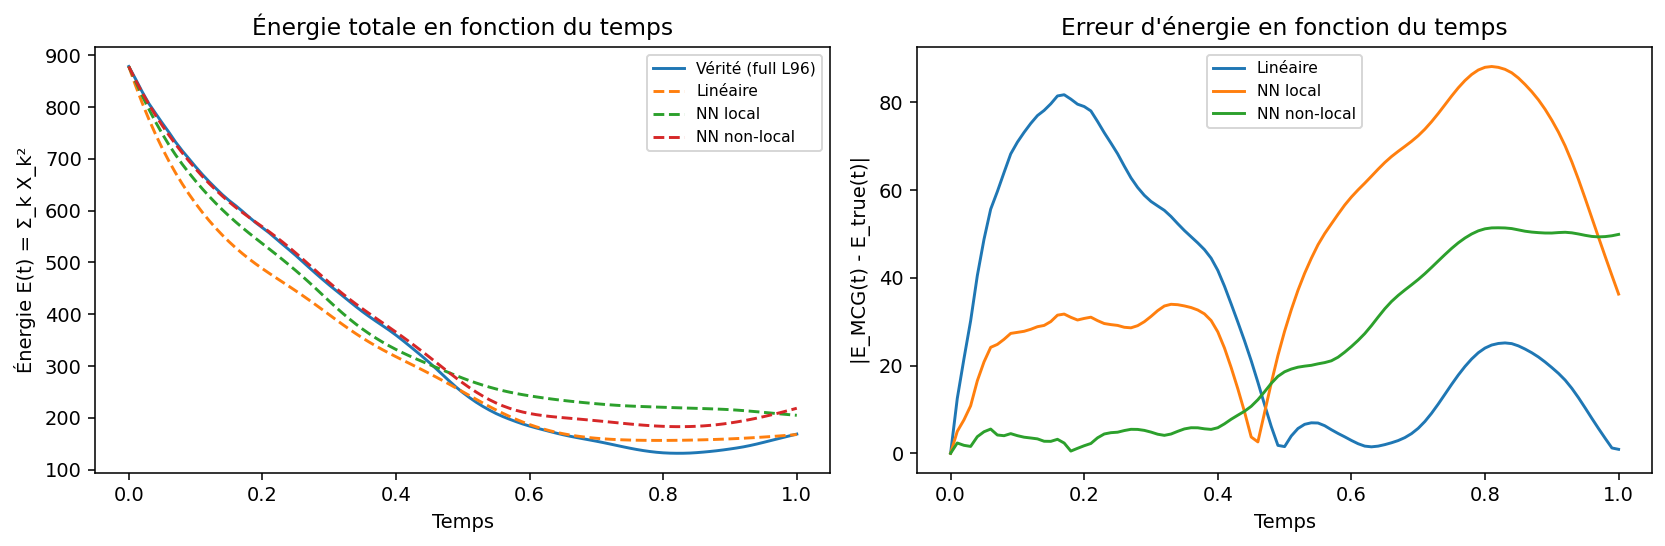

In [90]:
time_i = 101   

# 1) Calcul des énergies E(t) = somme_k X_k(t)^2
E_full      = np.sum(X_full[:time_i, :]**2, axis=1)
E_linear    = np.sum(Xnn_linear[:time_i, :]**2, axis=1)
E_local     = np.sum(Xnn_local[:time_i, :]**2, axis=1)
E_nonlocal  = np.sum(Xnn_nonlocal[:time_i, :]**2, axis=1)

# 2) Erreurs d'énergie absolues par rapport à la vérité
errE_linear   = np.abs(E_linear   - E_full)
errE_local    = np.abs(E_local    - E_full)
errE_nonlocal = np.abs(E_nonlocal - E_full)

# 3) Tracés
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=140)

# --- a) Energies brutes E(t) ---
ax[0].plot(t[:time_i], E_full,      label="Vérité (full L96)", linewidth=1.5)
ax[0].plot(t[:time_i], E_linear,    "--", label="Linéaire")
ax[0].plot(t[:time_i], E_local,     "--", label="NN local")
ax[0].plot(t[:time_i], E_nonlocal,  "--", label="NN non-local")

ax[0].set_xlabel("Temps")
ax[0].set_ylabel("Énergie E(t) = Σ_k X_k²")
ax[0].set_title("Énergie totale en fonction du temps")
ax[0].legend(fontsize=8)

# --- b) Erreur d'énergie |E_mod - E_true| ---
ax[1].plot(t[:time_i], errE_linear,   label="Linéaire")
ax[1].plot(t[:time_i], errE_local,    label="NN local")
ax[1].plot(t[:time_i], errE_nonlocal, label="NN non-local")

ax[1].set_xlabel("Temps")
ax[1].set_ylabel("|E_MCG(t) - E_true(t)|")
ax[1].set_title("Erreur d'énergie en fonction du temps")
ax[1].legend(fontsize=8)

plt.tight_layout()
plt.show()


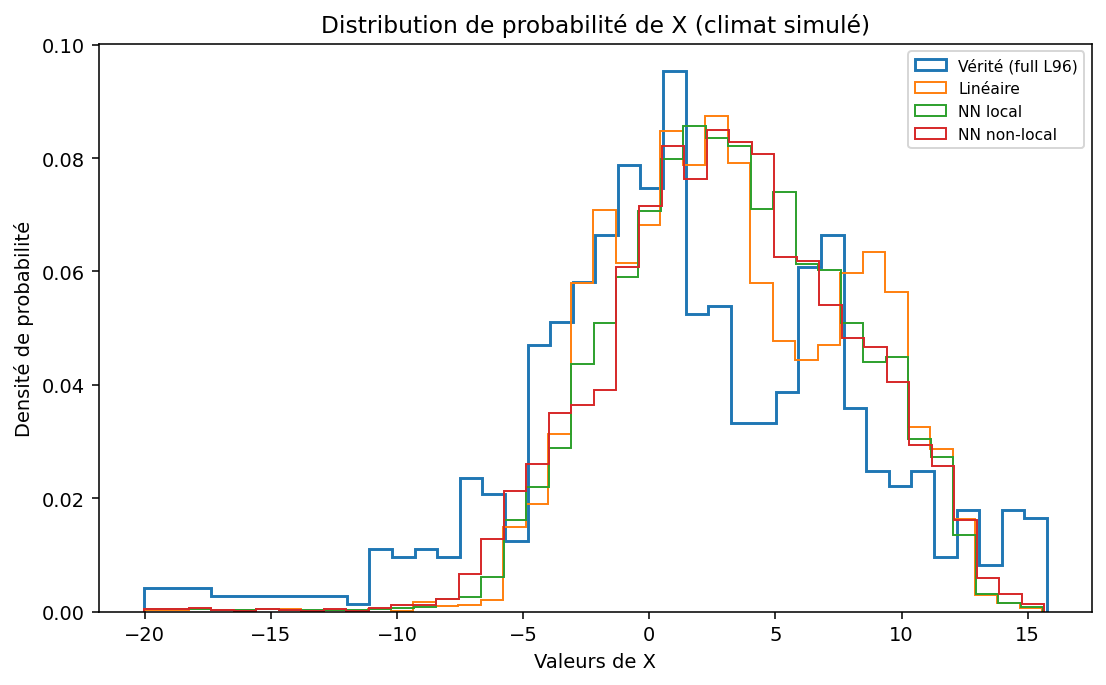

In [91]:
T_test = 10

#1 prevision par modèle
Xnn_linear, Xnn_local, Xnn_nonlocal,t = init_model(T_test)

# Longueur réelle renvoyée par le GCM (souvent n_steps + 1)
n_steps_model, K = Xnn_linear.shape  # K = nombre de points de grille

# Fenêtre de vérité de même longueur que les prévisions
i0=0

X_full_vals     = X_full_window.reshape(-1)
X_linear_vals   = Xnn_linear.reshape(-1)
X_local_vals    = Xnn_local.reshape(-1)
X_nonlocal_vals = Xnn_nonlocal.reshape(-1)


bins = 40  
plt.figure(figsize=(8, 5), dpi=140)

plt.hist(X_full_vals,     bins=bins, density=True,histtype="step", linewidth=1.5, label="Vérité (full L96)")
plt.hist(X_linear_vals,   bins=bins, density=True,histtype="step", linewidth=1.0, label="Linéaire")
plt.hist(X_local_vals,    bins=bins, density=True,histtype="step", linewidth=1.0, label="NN local")
plt.hist(X_nonlocal_vals, bins=bins, density=True,histtype="step", linewidth=1.0, label="NN non-local")

plt.xlabel("Valeurs de X")
plt.ylabel("Densité de probabilité")
plt.title("Distribution de probabilité de X (climat simulé)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [92]:
Moy_linear   = np.abs(np.mean(X_full) - np.mean(Xnn_linear))
Moy_local    = np.abs(np.mean(X_full) - np.mean(Xnn_local))
Moy_nonlocal = np.abs(np.mean(X_full) - np.mean(Xnn_nonlocal))
print("Moyenne climatique modele lineaire : ", round(Moy_linear,5))
print("Moyenne climatique modele local : ", round(Moy_local,5))
print("Moyenne climatique modele nonlocal : ", round(Moy_nonlocal,5))

Moyenne climatique modele lineaire :  0.17351
Moyenne climatique modele local :  0.15495
Moyenne climatique modele nonlocal :  0.25874


In [93]:
def edist(x_true, x_model, n_grid=200):
    
    x_true = np.asarray(x_true)
    x_model = np.asarray(x_model)

    # Grille commune de x
    xmin = min(x_true.min(), x_model.min())
    xmax = max(x_true.max(), x_model.max())
    x_grid = np.linspace(xmin, xmax, n_grid)

    # CDF empirique via searchsorted (rapide)
    true_sorted  = np.sort(x_true)
    model_sorted = np.sort(x_model)

    cdf_true  = np.searchsorted(true_sorted,  x_grid, side="right") / true_sorted.size
    cdf_model = np.searchsorted(model_sorted, x_grid, side="right") / model_sorted.size

    # Intégrale de la différence absolue
    E_dist = np.trapezoid(np.abs(cdf_true - cdf_model), x_grid)
    return E_dist


In [94]:
E_dist_linear   = edist(X_full_vals, X_linear_vals)
E_dist_local    = edist(X_full_vals, X_local_vals)
E_dist_nonlocal = edist(X_full_vals, X_nonlocal_vals)

print(f"E_dist (linéaire)   = {E_dist_linear:.4f}")
print(f"E_dist (NN local)   = {E_dist_local:.4f}")
print(f"E_dist (NN nonlocal)= {E_dist_nonlocal:.4f}")


E_dist (linéaire)   = 2.0278
E_dist (NN local)   = 2.0649
E_dist (NN nonlocal)= 1.9085


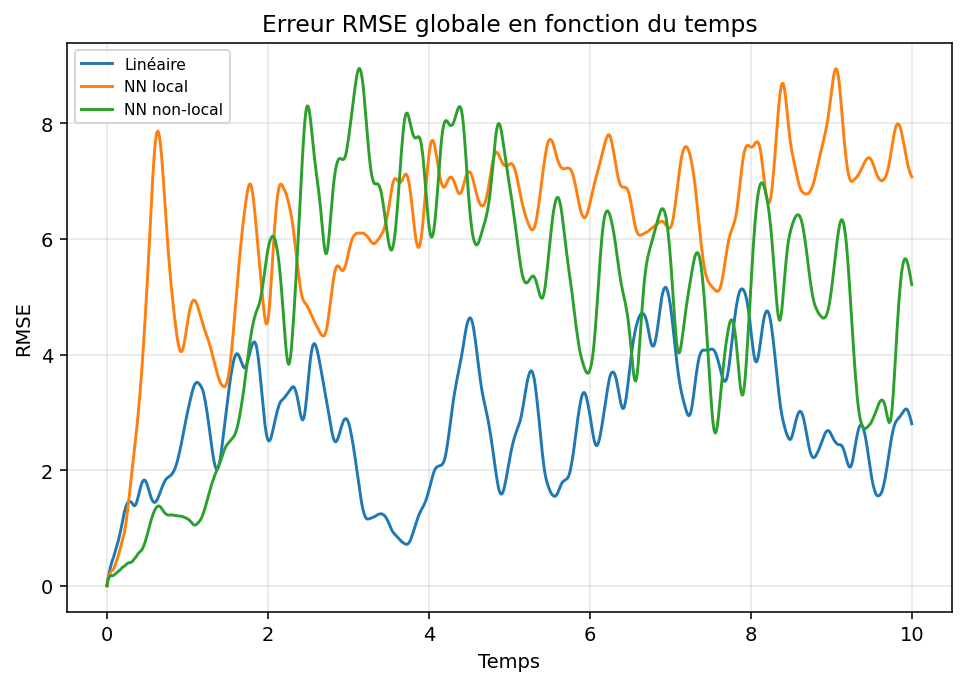

In [96]:

X_full_window = X_full[i0 * 10 : i0 * 10 + n_steps_model, :]

# Erreur au carré (temps x k)
sqerr_linear   = (Xnn_linear   - X_full_window)**2
sqerr_local    = (Xnn_local    - X_full_window)**2
sqerr_nonlocal = (Xnn_nonlocal - X_full_window)**2

# RMSE dans l’espace (moyenne sur k)
rmse_linear   = np.sqrt(np.mean(sqerr_linear,   axis=1))
rmse_local    = np.sqrt(np.mean(sqerr_local,    axis=1))
rmse_nonlocal = np.sqrt(np.mean(sqerr_nonlocal, axis=1))

# Tracé
plt.figure(figsize=(7,5), dpi=140)
plt.plot(t, rmse_linear,   label="Linéaire")
plt.plot(t, rmse_local,    label="NN local")
plt.plot(t, rmse_nonlocal, label="NN non-local")

plt.xlabel("Temps")
plt.ylabel("RMSE")
plt.title("Erreur RMSE globale en fonction du temps")
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
